# Case 2: User KGI 04

## Import Dependencies

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor

## Data Loading

In [2]:
DATA_PATH = "./Dataset/"
CSV_FILES = ["15_9-F-1 A.csv", "15_9-F-1 B.csv", "15_9-F-1 C.csv", "15_9-F-11 A.csv", "15_9-F-11 B.csv"]

def load_data(file_paths):
    all_data = []
    
    for file_path in file_paths:
        try:
            full_path = os.path.join(DATA_PATH, file_path)
            df = pd.read_csv(full_path)
            
            well_name = os.path.basename(file_path).split('.')[0]
            df['WELL'] = well_name
            
            all_data.append(df)
            print(f"Loaded {file_path} successfully")
        except FileNotFoundError:
            print(f"Warning: File {file_path} not found. Skipping.")
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
    
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
    return combined_df

file_paths = [os.path.join(DATA_PATH, file) for file in CSV_FILES]
df = load_data(CSV_FILES)

Loaded 15_9-F-1 A.csv successfully
Loaded 15_9-F-1 B.csv successfully
Loaded 15_9-F-1 C.csv successfully
Loaded 15_9-F-11 A.csv successfully
Loaded 15_9-F-11 B.csv successfully
Combined dataset shape: (33673, 9)


## Simple Data Exploration

In [4]:
print("\n--- Data Exploration ---")
print(f"Dataset Shape: {df.shape}")
print("First 5 rows:")
print(df.head())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nMissing Values Percentage:")
print((missing_values / len(df)) * 100)


--- Data Exploration ---
Dataset Shape: (33673, 9)
First 5 rows:
    DEPTH    NPHI    RHOB      GR       RT     PEF    CALI       DT  \
0  3100.0  0.0481  2.6067  8.3222  10.1810  7.5681  8.5781  60.6463   
1  3100.1  0.0481  2.6061  8.5168  10.0395  7.5860  8.5781  60.6713   
2  3100.2  0.0483  2.6063  8.3134   9.9846  7.6333  8.5781  60.7070   
3  3100.3  0.0486  2.6078  8.6389   9.9122  7.6751  8.5781  60.7455   
4  3100.4  0.0488  2.6091  8.2602   9.8524  7.6777  8.5781  60.7840   

         WELL  
0  15_9-F-1 A  
1  15_9-F-1 A  
2  15_9-F-1 A  
3  15_9-F-1 A  
4  15_9-F-1 A  

Basic Statistics:
              DEPTH          NPHI          RHOB            GR            RT  \
count  33673.000000  22814.000000  22870.000000  33489.000000  33209.000000   
mean    3225.772028      0.183379      2.461276     41.988215    429.736408   
std      287.753501      0.084425      0.148896     50.460093   5097.033177   
min     2600.000000      0.042000      2.033000      0.969100      0.065000 

## Basic Data Visualization


--- Data Visualization ---
Creating visualizations...


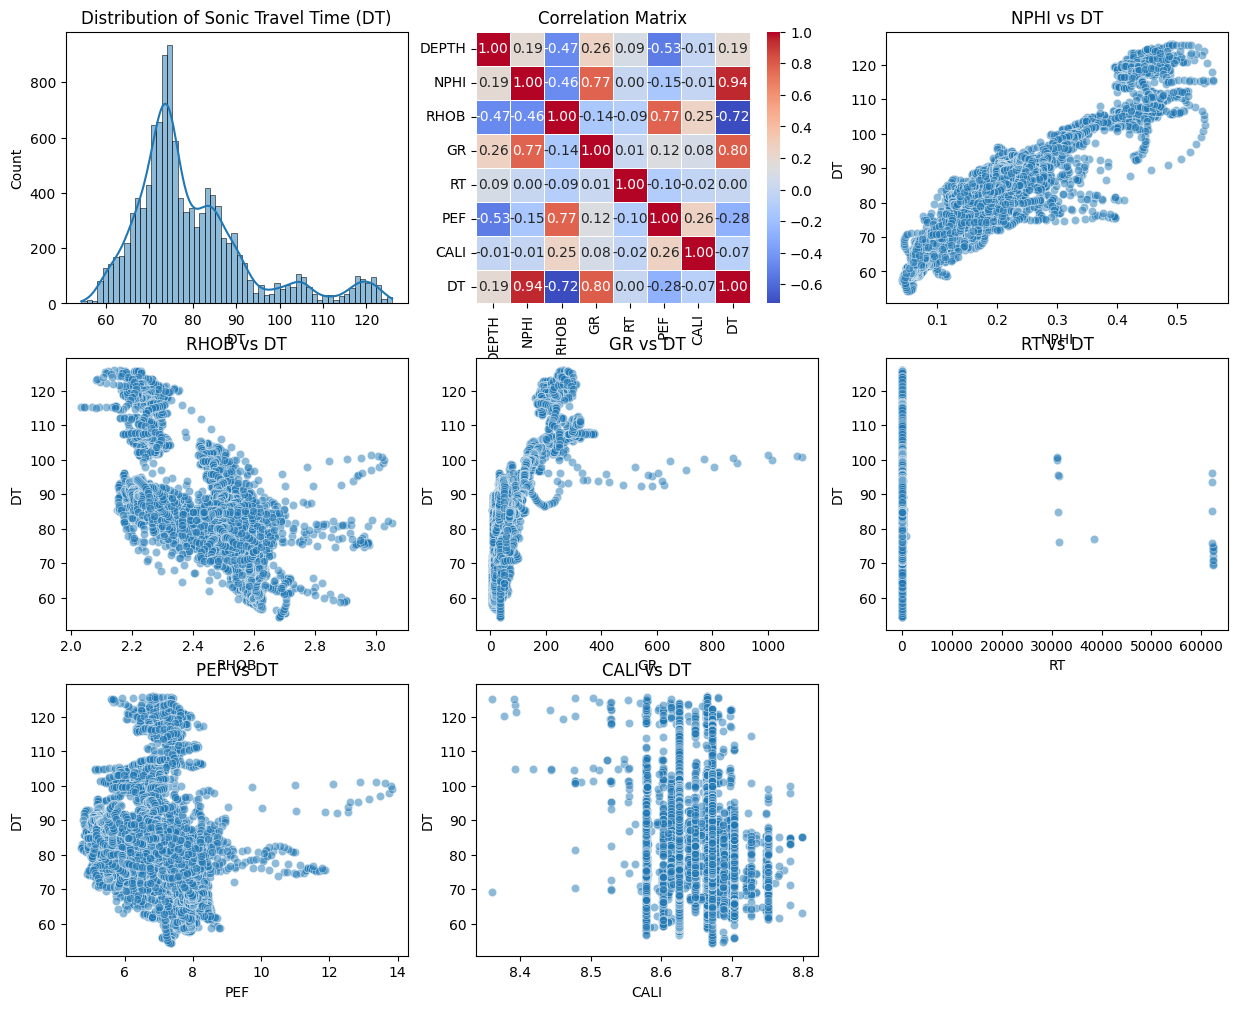

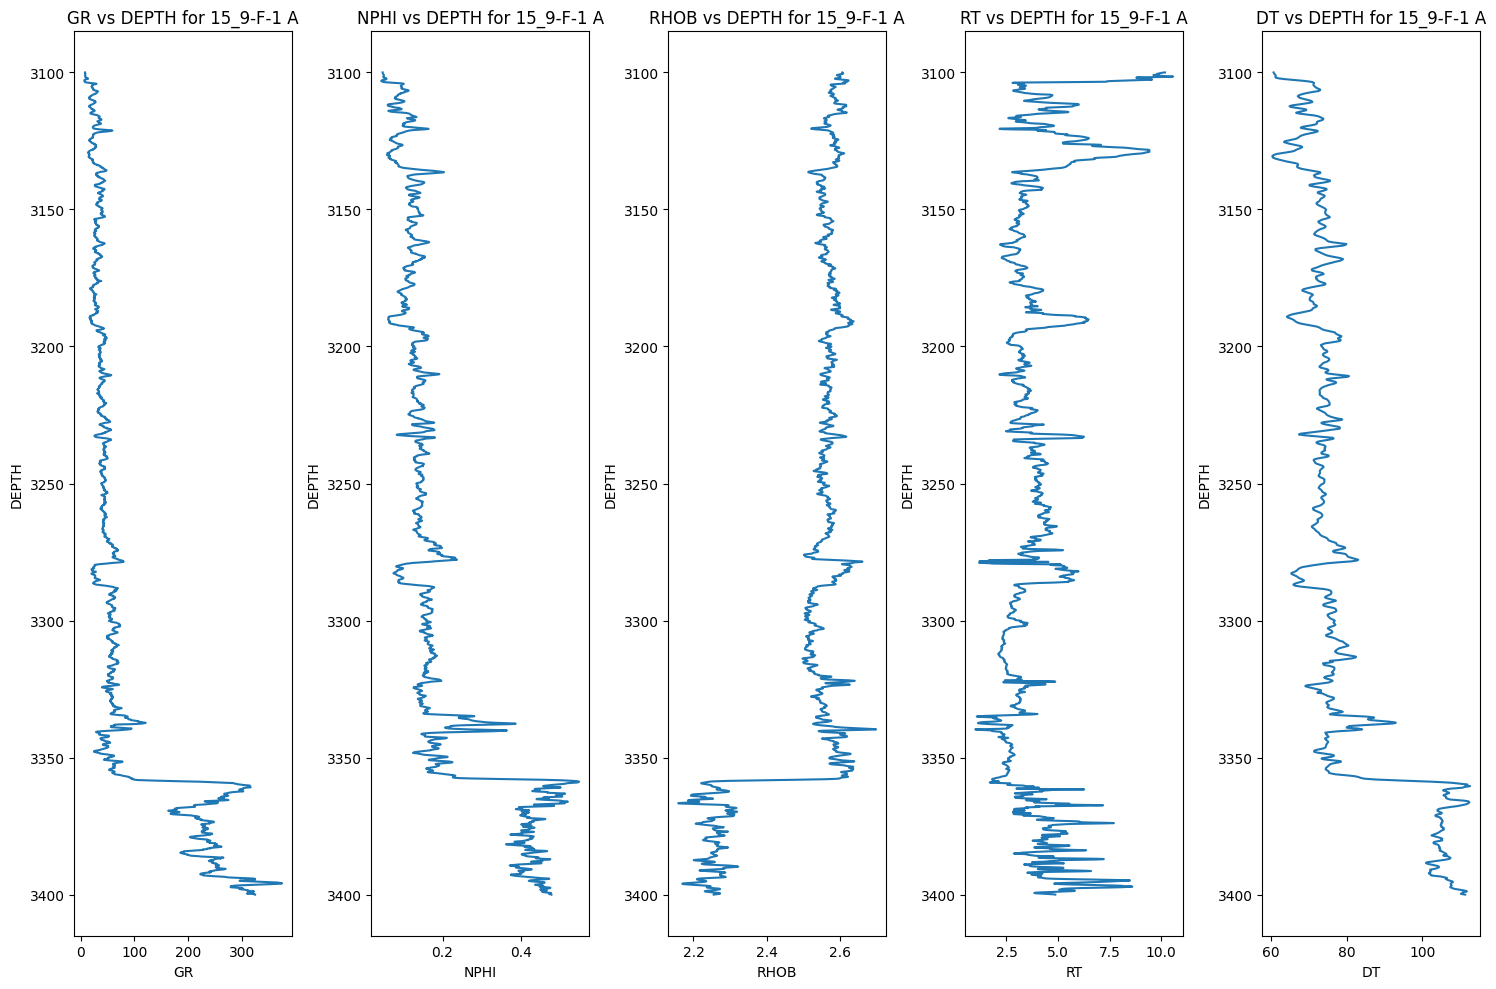

In [9]:
print("\n--- Data Visualization ---")
print("Creating visualizations...")

plt.figure(figsize=(15, 12))

plt.subplot(3, 3, 1)
sns.histplot(df['DT'].dropna(), kde=True)
plt.title('Distribution of Sonic Travel Time (DT)')

plt.subplot(3, 3, 2)
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')

features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
plot_pos = 3

for feature in features:
    plt.subplot(3, 3, plot_pos)
    sns.scatterplot(x=feature, y='DT', data=df, alpha=0.5)
    plt.title(f'{feature} vs DT')
    plot_pos += 1

if 'WELL' in df.columns:
    well_name = df['WELL'].unique()[0]
    well_data = df[df['WELL'] == well_name].copy()
    
    plt.figure(figsize=(15, 10))

    logs_to_plot = ['GR', 'NPHI', 'RHOB', 'RT', 'DT']
    num_logs = len(logs_to_plot)
    
    for i, log in enumerate(logs_to_plot):
        plt.subplot(1, num_logs, i+1)
        plt.plot(well_data[log], well_data['DEPTH'])
        plt.xlabel(log)
        plt.ylabel('DEPTH')
        plt.gca().invert_yaxis()
        plt.title(f'{log} vs DEPTH for {well_name}')
    
    plt.tight_layout()
    plt.savefig('depth_logs_plot.png')

plt.tight_layout()
plt.savefig('exploratory_analysis.png')

## Data Preprocessing

### Data Imputation

In [ ]:
print("\nApplying domain-specific imputation strategies...")

wells = df['WELL'].unique()
processed_dfs = []

for well in wells:
    print(f"Processing well: {well}")
    well_data = df[df['WELL'] == well].copy()
    
    well_data = well_data.sort_values('DEPTH')
    
    dense_logs = ['GR', 'RT']
    for log in dense_logs:
        if log in well_data.columns:
            well_data[log] = well_data[log].interpolate(method='cubic', limit_direction='both')
    
    sparse_logs = ['NPHI', 'RHOB', 'PEF', 'CALI']
    for log in sparse_logs:
        if log in well_data.columns:
            well_data[log] = well_data[log].interpolate(method='linear', limit_direction='both')
    
    if 'DT' in well_data.columns:
        missing_dt_mask = well_data['DT'].isnull()
        missing_dt_count = missing_dt_mask.sum()
        
        if missing_dt_count > 0:
            print(f"  Imputing {missing_dt_count} missing DT values using physics-based relationships")
            
            complete_data = well_data.dropna(subset=['DT', 'RHOB', 'NPHI', 'GR']).copy()
            
            if len(complete_data) >= 10:
                
                features = ['RHOB', 'NPHI', 'GR', 'RT']
                available_features = [f for f in features if f in complete_data.columns and complete_data[f].isnull().sum() == 0]
                
                if len(available_features) >= 2:  
                    X_mini = complete_data[available_features]
                    y_mini = complete_data['DT']
                    
                    mini_model = RandomForestRegressor(n_estimators=50, random_state=42)
                    mini_model.fit(X_mini, y_mini)
                    
                    missing_dt_rows = well_data[missing_dt_mask].copy()
                    valid_prediction_mask = ~missing_dt_rows[available_features].isnull().any(axis=1)
                    
                    if valid_prediction_mask.sum() > 0:
                        X_predict = missing_dt_rows.loc[valid_prediction_mask, available_features]
                        predictions = mini_model.predict(X_predict)
                        

                        well_data.loc[missing_dt_mask & valid_prediction_mask, 'DT'] = predictions
                        print(f"    Successfully predicted {len(predictions)} DT values using RandomForest")

            well_data['DT'] = well_data['DT'].interpolate(method='linear', limit_direction='both')
    
    processed_dfs.append(well_data)

df = pd.concat(processed_dfs, ignore_index=True)

print("\nApplying KNN imputation for remaining missing values...")
remaining_nulls = df.select_dtypes(include=[np.number]).isnull().sum()
columns_with_nulls = remaining_nulls[remaining_nulls > 0].index.tolist()

if columns_with_nulls:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if 'WELL' in numeric_cols:
        numeric_cols.remove('WELL')
    
    impute_df = df[numeric_cols].copy()
    
    knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
    imputed_values = knn_imputer.fit_transform(impute_df)
    
    df[numeric_cols] = imputed_values
    
    print("KNN imputation completed")

final_nulls = df.isnull().sum()
print("\nRemaining missing values after all imputation steps:")
print(final_nulls[final_nulls > 0])

if final_nulls.sum() > 0:
    df = df.fillna(df.mean())
    print("All missing values have been handled")

print(f"Final dataset contains {len(df)} rows")


Applying domain-specific imputation strategies...
Processing well: 15_9-F-1 A
Processing well: 15_9-F-1 B
  Imputing 403 missing DT values using physics-based relationships
    Successfully predicted 314 DT values using RandomForest
Processing well: 15_9-F-1 C
  Imputing 11201 missing DT values using physics-based relationships
Processing well: 15_9-F-11 A
  Imputing 386 missing DT values using physics-based relationships
    Successfully predicted 280 DT values using RandomForest
Processing well: 15_9-F-11 B
  Imputing 10201 missing DT values using physics-based relationships

Applying KNN imputation for remaining missing values...
KNN imputation completed

Remaining missing values after all imputation steps:
Series([], dtype: int64)
Final dataset contains 33673 rows


### Outlier Handling

In [13]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

for column in df.select_dtypes(include=[np.number]).columns:
    if column not in ['DEPTH', 'WELL']:
        outliers, lb, ub = detect_outliers(df, column)
        print(f"Outliers in {column}: {len(outliers)}, Range: ({lb:.2f}, {ub:.2f})")

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

for column in df.select_dtypes(include=[np.number]).columns:
    if column not in ['DEPTH', 'WELL']:
        df = handle_outliers(df, column)

print("Outliers handled using capping method")

Outliers in NPHI: 0, Range: (-0.05, 0.35)
Outliers in RHOB: 0, Range: (2.22, 2.83)
Outliers in GR: 0, Range: (-40.83, 105.19)
Outliers in RT: 0, Range: (-3.27, 10.47)
Outliers in PEF: 0, Range: (4.02, 9.95)
Outliers in CALI: 0, Range: (8.44, 8.81)
Outliers in DT: 0, Range: (45.08, 102.85)
Outliers handled using capping method
